In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# Neural Network Definition
class NeuralNetwork(nn.Module):
    def __init__(self, input_features, hidden_units=1024):
        super(NeuralNetwork, self).__init__()
        # self.ff = FourierFeatures(input_features, input_features*2, 4) # Double for sin and cos
        self.fc1 = nn.Linear(input_features, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, hidden_units)
        self.fc4 = nn.Linear(hidden_units, hidden_units)
        self.fc_out = nn.Linear(hidden_units, 1)  # Adjust output features as necessary
        self.relu = nn.ReLU()

    def forward(self, x):
        # x = self.ff(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        return self.fc_out(x)

In [42]:
# Training Setup
def train(model, criterion, optimizer, data, epochs=2000, silent=False):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in data:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        if not silent and epoch % 100 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')

In [4]:
def target_function(x):
    return torch.sin(30*(x - 0.95)**4) * torch.cos(2*(x - 0.95)) + (x - 0.95)/2

In [5]:
# Fourier Transformation for feature layer for feature engineering
class FourierFeatureLayer(nn.Module):
    def __init__(self, input_dim, num_freqs=4, spectral_bias=1):
        super(FourierFeatureLayer, self).__init__()
        self.input_dim = input_dim
        self.num_freqs = num_freqs
        self.spectral_bias = spectral_bias
        self.freqs = torch.arange(1, num_freqs + 1, dtype=torch.float32)
        self.scale = torch.pow(self.spectral_bias, -self.freqs)
        self.phase = torch.randn(num_freqs) * (2 * torch.pi)

    def forward(self, x):
        # Expand input to match batch size
        batch_size = x.shape[0]
        x = x.unsqueeze(1).repeat(1, self.num_freqs, 1)

        # Compute Fourier features
        features = torch.sin((x * self.freqs.unsqueeze(-1)) + self.phase.unsqueeze(-1))
        features = features * self.scale.unsqueeze(-1)

        return features.view(batch_size, -1)


In [6]:
# Generate random input tensor
inputs = torch.rand(100,1)
input_dim = 1
fourier_layer = FourierFeatureLayer(input_dim=input_dim, num_freqs=4, spectral_bias=1)

input_tensor = inputs

# Apply Fourier feature layer
output_tensor = fourier_layer(input_tensor)
print(output_tensor.shape)  # Output shape will be (batch_size, num_freqs * input_dim)

torch.Size([100, 4])


In [7]:
targets = target_function(inputs)

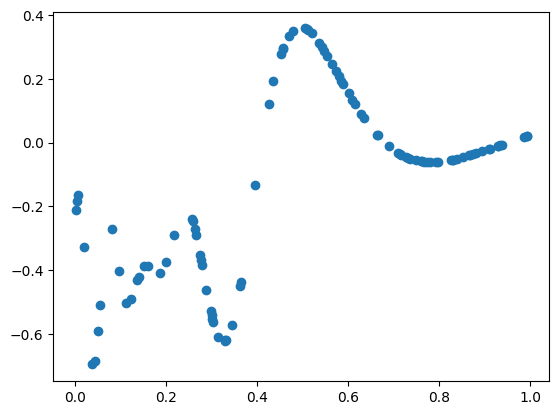

In [8]:
plt.scatter(x=inputs, y=targets)

In [9]:
output_tensor.shape

torch.Size([100, 4])

In [10]:
targets.shape

torch.Size([100, 1])

# Model and Training Initialization without Fourier Feature Transformation

In [11]:
model = NeuralNetwork(input_features=1)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Start training
train(model, criterion, optimizer, [(inputs, targets)])

print("Training completed")

Epoch 1, Loss: 0.0928926095366478
Epoch 101, Loss: 0.08171050250530243
Epoch 201, Loss: 0.07690571993589401
Epoch 301, Loss: 0.07358704507350922
Epoch 401, Loss: 0.07089266180992126
Epoch 501, Loss: 0.06850310415029526
Epoch 601, Loss: 0.06620283424854279
Epoch 701, Loss: 0.06406062096357346
Epoch 801, Loss: 0.06209548935294151
Epoch 901, Loss: 0.06032940372824669
Epoch 1001, Loss: 0.058713894337415695
Epoch 1101, Loss: 0.05719370022416115
Epoch 1201, Loss: 0.055747248232364655
Epoch 1301, Loss: 0.05434484779834747
Epoch 1401, Loss: 0.05305603891611099
Epoch 1501, Loss: 0.051897406578063965
Epoch 1601, Loss: 0.05081560090184212
Epoch 1701, Loss: 0.049839332699775696
Epoch 1801, Loss: 0.048943668603897095
Epoch 1901, Loss: 0.04811856895685196
Training completed


### Training Time ~ 1 min
100 data points with 2000 epochs

In [12]:
model.eval()  # Set the model to evaluation mode

NeuralNetwork(
  (fc1): Linear(in_features=1, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_out): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
)

# Model and Training Initialization with Fourier Feature Transformation

In [13]:
# Model and Training Initialization
model_fourier = NeuralNetwork(input_features=4)
optimizer2 = torch.optim.SGD(model_fourier.parameters(), lr=1e-3)

# Start training
train(model_fourier, criterion, optimizer2, [(output_tensor, targets)])

print("Training completed")

Epoch 1, Loss: 0.09016407281160355
Epoch 101, Loss: 0.07660459727048874
Epoch 201, Loss: 0.06804270297288895
Epoch 301, Loss: 0.0616782046854496
Epoch 401, Loss: 0.056480780243873596
Epoch 501, Loss: 0.05212695896625519
Epoch 601, Loss: 0.04848550260066986
Epoch 701, Loss: 0.045445606112480164
Epoch 801, Loss: 0.042895711958408356
Epoch 901, Loss: 0.04072931408882141
Epoch 1001, Loss: 0.038865529000759125
Epoch 1101, Loss: 0.037257611751556396
Epoch 1201, Loss: 0.03586240112781525
Epoch 1301, Loss: 0.03463507816195488
Epoch 1401, Loss: 0.03354102000594139
Epoch 1501, Loss: 0.03255382180213928
Epoch 1601, Loss: 0.031653884798288345
Epoch 1701, Loss: 0.030823590233922005
Epoch 1801, Loss: 0.030051372945308685
Epoch 1901, Loss: 0.029326824471354485
Training completed


In [14]:
model_fourier.eval()  # Set the model_fourier to evaluation mode

NeuralNetwork(
  (fc1): Linear(in_features=4, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_out): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
)

In [15]:
def calculate_mse(targets, predictions):
    return ((targets - predictions) ** 2).mean()

# Testing the Neural Network

In [16]:
x_test = torch.linspace(0, 1, 50).unsqueeze(1)  # Test input data
y_test = target_function(x_test)

# Apply Fourier feature layer
x_test_fourier = fourier_layer(x_test)
print(x_test_fourier.shape)  # Output shape will be (batch_size, num_freqs * input_dim)

torch.Size([50, 4])


In [17]:
# Disable gradient tracking since we're only doing inference
with torch.no_grad():
    # Pass the test input data through the model to get predictions
    predictions = model(x_test)

calculate_mse(y_test, predictions)

tensor(0.0398)

In [18]:
# Disable gradient tracking since we're only doing inference
with torch.no_grad():
    # Pass the test input data through the model to get predictions
    predictions_fourier = model_fourier(x_test_fourier)

calculate_mse(y_test, predictions_fourier)

tensor(0.0249)

### Test Loss
 - Without the fourier layer - 0.0398
 - With the fourier layer - 0.0249

### Conclusions

 1. We can observe that adding the fourier layer betters the test loss by ~37.5% without practically adding any extra time to the training

 2. Additionally we can observe that the test loss is similar to the training loss and hence we can conclude that the model isn't overfitting and is therefore generalizing well

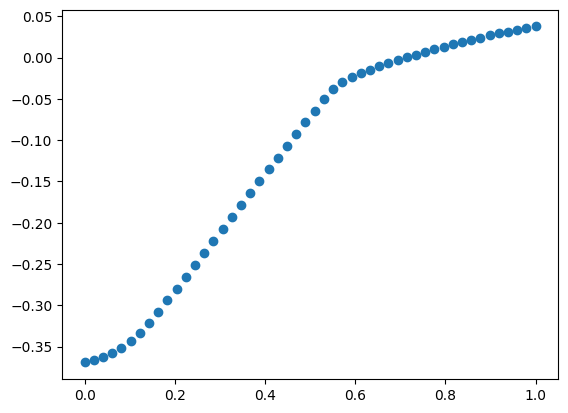

In [19]:
plt.scatter(x=x_test, y=predictions)

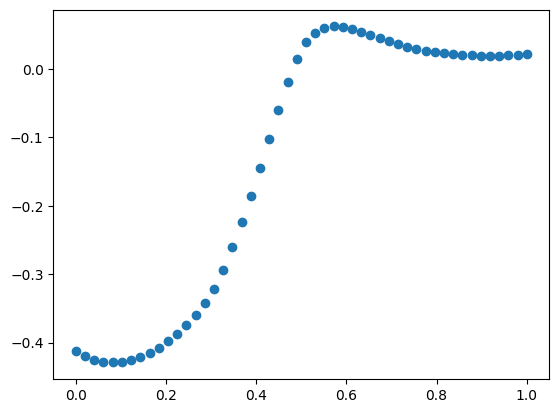

In [20]:
plt.scatter(x=x_test, y=predictions_fourier)

# Predictions at each training data point

We want to find difference between the test losses taking the whole data for training and leaving a certain data point out. This difference tells us how important the point is to training the model

Since we observed that the test loss and trainig loss are similar and our models is generalising well, the training loss is a good indication of the expected test loss at the given points 

We can now observe the follwoing:

Test Loss 2 - Test Loss 1 = (y_actual - y_pred_loo) - (y_actual - y_pred_whole_data) = y_pred_whole_data - y_pred_loo

Hence we calculate the predictions at each of the training points to calulate the differece between the test losses

In [23]:
with torch.no_grad():
    predictions_whole_data = model_fourier(output_tensor)

# Calculating the Leave-One-Out Cross-Validation predictions

In [44]:
loo_preds = []
for i in range(targets.shape[0]):
    # Leave out the ith training example
    X_loo = torch.cat((output_tensor[:i], output_tensor[i+1:]))
    y_loo = torch.cat((targets[:i], targets[i+1:]))

    # Train the model on the remaining points
    model_loo = NeuralNetwork(input_features=4)
    optimizer_loo = torch.optim.SGD(model_loo.parameters(), lr=1e-3)

    # Start training
    train(model_loo, criterion, optimizer_loo, [(X_loo, y_loo)], silent=True)

    if i % 4 == 0:
        print(f'Completed {i+1} iterations')

    # Make predictions on the left out point
    with torch.no_grad():
        y_pred = model_loo(output_tensor[i].unsqueeze(0))
        loo_preds.append(y_pred.item())

loo_preds = np.array(loo_preds)
print(f'Completed {targets.shape[0]} iterations')

Completed 1 iterations
Completed 5 iterations
Completed 9 iterations
Completed 13 iterations
Completed 17 iterations
Completed 21 iterations
Completed 25 iterations
Completed 29 iterations
Completed 33 iterations
Completed 37 iterations
Completed 41 iterations
Completed 45 iterations
Completed 49 iterations
Completed 53 iterations
Completed 57 iterations
Completed 61 iterations
Completed 65 iterations
Completed 69 iterations
Completed 73 iterations
Completed 77 iterations
Completed 81 iterations
Completed 85 iterations
Completed 89 iterations
Completed 93 iterations
Completed 97 iterations
Completed 100 iterations


### LOOCV Run Time
100-fold LOOCV took 84 min and hence around 50 seconds per fold


In [45]:
print(predictions_whole_data.shape)
print(loo_preds.shape)

torch.Size([100, 1])
(100,)


In [54]:
predictions_whole_data_np = np.array(predictions_whole_data).reshape(-1)
predictions_whole_data_np.shape

(100,)

# Calculate Error dur to missing point in training

In [55]:
loo_error = predictions_whole_data_np - loo_preds

In [56]:
loo_error.shape

(100,)

In [67]:
np.save('loo_error.npy', loo_error)

# Testing out Gaussian Process Model implemnetation with Zero Mean Prior and whole dataset as training data

### Important Note:
We are utilising a Teacher-Student model for the Gaussian Process Model with the Neural Network

We pass the x_test and y_pred to the Gaussian Process Model as the model trains better when we first predict using the more complex Neural Network model with higher training time and then pass its predictions as the y_train for the Gaussian Process Model

In [ ]:
import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
import matplotlib as mpl
from jax import jit

In [24]:
x_test_fourier_jax = jnp.array(x_test_fourier)
predictions_fourier_jax = jnp.array(predictions_fourier)
y_test_jax = jnp.array(y_test)

In [25]:
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

In [26]:
key = jr.key(123)
key, subkey = jr.split(key)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\cola\backends\backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\cola\backends\backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


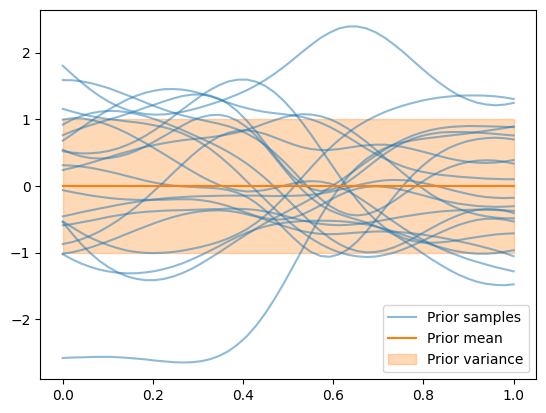

In [27]:
prior_dist = prior.predict(x_test_fourier_jax)

prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(20,))


def clean_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="best")
    return ax


fig, ax = plt.subplots()
ax.plot(x_test, samples.T, alpha=0.5, color=cols[0], label="Prior samples")
ax.plot(x_test, prior_mean, color=cols[1], label="Prior mean")
ax.fill_between(
    x_test.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    color=cols[1],
    label="Prior variance",
)
ax.legend(loc="best")
ax = clean_legend(ax)

In [28]:
D = gpx.Dataset(X=x_test_fourier_jax, y=y_test_jax)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood

c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


In [29]:
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=D)

c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\cola\backends\backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Array(51.279022, dtype=float32)

In [30]:
negative_mll = jit(negative_mll)

In [31]:
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=D,
)

         Current function value: -43.662838
         Iterations: 11
         Function evaluations: 157
         Gradient evaluations: 144


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [32]:
latent_dist = opt_posterior.predict(x_test_fourier_jax, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\cola\backends\backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


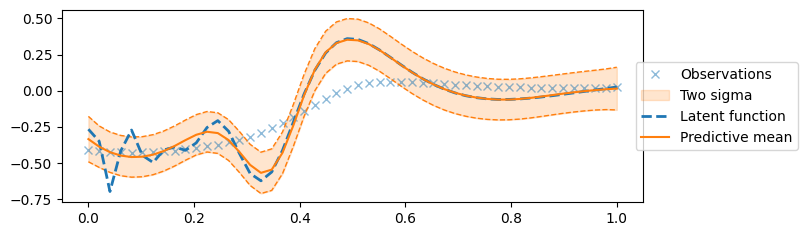

In [33]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(x_test, predictions_fourier, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    x_test.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    x_test,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    x_test,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    x_test, y_test, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax.plot(x_test, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))

# Calculating the Leave-One-Out probability using GP

In [47]:
loo_means_tensor = []
loo_stds_tensor = []

loo_means = []
loo_stds = []

for i in range(targets.shape[0]):

    # Leave out the ith training example
    X_loo = torch.cat((output_tensor[:i], output_tensor[i+1:]))
    y_loo = torch.cat((targets[:i], targets[i+1:]))

    X_loo_jax = jnp.array(X_loo)
    y_loo_jax = jnp.array(y_loo)

    D = gpx.Dataset(X=X_loo_jax, y=y_loo_jax)

    likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
    posterior = prior * likelihood

    negative_mll = gpx.objectives.ConjugateMLL(negative=True)
    negative_mll(posterior, train_data=D)

    negative_mll = jit(negative_mll)

    opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=D,
    )

    x_left = output_tensor[i].unsqueeze(0)
    x_left_jax = jnp.array(x_left)

    latent_dist = opt_posterior.predict(x_left_jax, train_data=D)
    predictive_dist = opt_posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()

    loo_means_tensor.append(predictive_mean)
    loo_stds_tensor.append(predictive_std)

    loo_means.append(predictive_mean[0])
    loo_stds.append(predictive_std[0])

    if i % 4 == 0:
        print(f'Completed {i+1} iterations')

print(f'Completed {targets.shape[0]} iterations')

c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -268.489838
         Iterations: 16
         Function evaluations: 96
         Gradient evaluations: 84
Completed 1 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This 

         Current function value: -268.692139
         Iterations: 24
         Function evaluations: 133
         Gradient evaluations: 124


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -270.389862
         Iterations: 22
         Function evaluations: 92
         Gradient evaluations: 81


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.751495
         Iterations: 12
         Function evaluations: 86
         Gradient evaluations: 77


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.649994
         Iterations: 11
         Function evaluations: 91
         Gradient evaluations: 80
Completed 5 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.820923
         Iterations: 14
         Function evaluations: 101
         Gradient evaluations: 89


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.594818
         Iterations: 13
         Function evaluations: 96
         Gradient evaluations: 85


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.970428
         Iterations: 13
         Function evaluations: 103
         Gradient evaluations: 92


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -269.805023
         Iterations: 15
         Function evaluations: 100
         Gradient evaluations: 89
Completed 9 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -269.211731
         Iterations: 14
         Function evaluations: 259
         Gradient evaluations: 231


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.602753
         Iterations: 11
         Function evaluations: 103
         Gradient evaluations: 93


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.658417
         Iterations: 31
         Function evaluations: 206
         Gradient evaluations: 188


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.496490
         Iterations: 11
         Function evaluations: 79
         Gradient evaluations: 69
Completed 13 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.495331
         Iterations: 16
         Function evaluations: 89
         Gradient evaluations: 79


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.662048
         Iterations: 13
         Function evaluations: 175
         Gradient evaluations: 164


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -269.106720
         Iterations: 15
         Function evaluations: 213
         Gradient evaluations: 192


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.734100
         Iterations: 15
         Function evaluations: 163
         Gradient evaluations: 150
Completed 17 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.381042
         Iterations: 11
         Function evaluations: 74
         Gradient evaluations: 63


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.539978
         Iterations: 9
         Function evaluations: 73
         Gradient evaluations: 63


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.584290
         Iterations: 12
         Function evaluations: 92
         Gradient evaluations: 81


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -270.257019
         Iterations: 16
         Function evaluations: 100
         Gradient evaluations: 89
Completed 21 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -269.224243
         Iterations: 14
         Function evaluations: 89
         Gradient evaluations: 78


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.732208
         Iterations: 15
         Function evaluations: 103
         Gradient evaluations: 92


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.535522
         Iterations: 12
         Function evaluations: 105
         Gradient evaluations: 94


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.367584
         Iterations: 12
         Function evaluations: 95
         Gradient evaluations: 83
Completed 25 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.736237
         Iterations: 10
         Function evaluations: 79
         Gradient evaluations: 67


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.675476
         Iterations: 14
         Function evaluations: 113
         Gradient evaluations: 103


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.863586
         Iterations: 29
         Function evaluations: 200
         Gradient evaluations: 178


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -269.158539
         Iterations: 27
         Function evaluations: 147
         Gradient evaluations: 136
Completed 29 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.455200
         Iterations: 11
         Function evaluations: 83
         Gradient evaluations: 72


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.759369
         Iterations: 22
         Function evaluations: 181
         Gradient evaluations: 169


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.357605
         Iterations: 13
         Function evaluations: 90
         Gradient evaluations: 79


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -272.070801
         Iterations: 22
         Function evaluations: 119
         Gradient evaluations: 107
Completed 33 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.617065
         Iterations: 12
         Function evaluations: 97
         Gradient evaluations: 86


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.602173
         Iterations: 13
         Function evaluations: 142
         Gradient evaluations: 124


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -269.845520
         Iterations: 12
         Function evaluations: 98
         Gradient evaluations: 86


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.596588
         Iterations: 15
         Function evaluations: 152
         Gradient evaluations: 140
Completed 37 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.434113
         Iterations: 9
         Function evaluations: 146
         Gradient evaluations: 133


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.918884
         Iterations: 13
         Function evaluations: 151
         Gradient evaluations: 130


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -270.252991
         Iterations: 20
         Function evaluations: 85
         Gradient evaluations: 73


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.600525
         Iterations: 13
         Function evaluations: 172
         Gradient evaluations: 159
Completed 41 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -271.021484
         Iterations: 17
         Function evaluations: 163
         Gradient evaluations: 147


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.610352
         Iterations: 14
         Function evaluations: 98
         Gradient evaluations: 86


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.448547
         Iterations: 14
         Function evaluations: 115
         Gradient evaluations: 103


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.694550
         Iterations: 13
         Function evaluations: 92
         Gradient evaluations: 82
Completed 45 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.813629
         Iterations: 14
         Function evaluations: 163
         Gradient evaluations: 149


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.437164
         Iterations: 10
         Function evaluations: 91
         Gradient evaluations: 81


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.673584
         Iterations: 13
         Function evaluations: 108
         Gradient evaluations: 97


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -269.253998
         Iterations: 11
         Function evaluations: 97
         Gradient evaluations: 86
Completed 49 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -269.096497
         Iterations: 17
         Function evaluations: 97
         Gradient evaluations: 86


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -271.001709
         Iterations: 12
         Function evaluations: 95
         Gradient evaluations: 85


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -269.408356
         Iterations: 14
         Function evaluations: 98
         Gradient evaluations: 87


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.845703
         Iterations: 11
         Function evaluations: 110
         Gradient evaluations: 98
Completed 53 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.597443
         Iterations: 15
         Function evaluations: 100
         Gradient evaluations: 92


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.867432
         Iterations: 14
         Function evaluations: 101
         Gradient evaluations: 90


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -269.865204
         Iterations: 17
         Function evaluations: 222
         Gradient evaluations: 209


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -270.024323
         Iterations: 12
         Function evaluations: 91
         Gradient evaluations: 80
Completed 57 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -269.058685
         Iterations: 22
         Function evaluations: 106
         Gradient evaluations: 95


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.657867
         Iterations: 25
         Function evaluations: 174
         Gradient evaluations: 161


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.689484
         Iterations: 15
         Function evaluations: 182
         Gradient evaluations: 171


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -271.991455
         Iterations: 11
         Function evaluations: 90
         Gradient evaluations: 79
Completed 61 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -270.685028
         Iterations: 15
         Function evaluations: 103
         Gradient evaluations: 91


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -271.409607
         Iterations: 19
         Function evaluations: 101
         Gradient evaluations: 89


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -272.636536
         Iterations: 14
         Function evaluations: 93
         Gradient evaluations: 83


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.869965
         Iterations: 13
         Function evaluations: 168
         Gradient evaluations: 155
Completed 65 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.594238
         Iterations: 11
         Function evaluations: 96
         Gradient evaluations: 86


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -269.755371
         Iterations: 13
         Function evaluations: 148
         Gradient evaluations: 136


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.850098
         Iterations: 13
         Function evaluations: 99
         Gradient evaluations: 89


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -270.049286
         Iterations: 24
         Function evaluations: 158
         Gradient evaluations: 149
Completed 69 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -269.861359
         Iterations: 14
         Function evaluations: 110
         Gradient evaluations: 100


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -130.706451
         Iterations: 12
         Function evaluations: 164
         Gradient evaluations: 151


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -134.284409
         Iterations: 10
         Function evaluations: 148
         Gradient evaluations: 133


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.455994
         Iterations: 20
         Function evaluations: 102
         Gradient evaluations: 90
Completed 73 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -271.527039
         Iterations: 11
         Function evaluations: 90
         Gradient evaluations: 82


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -269.802002
         Iterations: 13
         Function evaluations: 97
         Gradient evaluations: 85


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.344421
         Iterations: 12
         Function evaluations: 91
         Gradient evaluations: 80


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.707550
         Iterations: 13
         Function evaluations: 95
         Gradient evaluations: 84
Completed 77 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.686615
         Iterations: 19
         Function evaluations: 103
         Gradient evaluations: 91


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -269.231445
         Iterations: 10
         Function evaluations: 91
         Gradient evaluations: 80


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -270.014191
         Iterations: 12
         Function evaluations: 145
         Gradient evaluations: 133


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.372986
         Iterations: 24
         Function evaluations: 184
         Gradient evaluations: 173
Completed 81 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.687042
         Iterations: 13
         Function evaluations: 75
         Gradient evaluations: 63


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -269.987396
         Iterations: 13
         Function evaluations: 115
         Gradient evaluations: 105


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -271.213440
         Iterations: 15
         Function evaluations: 147
         Gradient evaluations: 134


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -269.462372
         Iterations: 17
         Function evaluations: 164
         Gradient evaluations: 152
Completed 85 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -269.023071
         Iterations: 15
         Function evaluations: 97
         Gradient evaluations: 87


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -273.652740
         Iterations: 24
         Function evaluations: 169
         Gradient evaluations: 156


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.454803
         Iterations: 13
         Function evaluations: 167
         Gradient evaluations: 155


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.658722
         Iterations: 18
         Function evaluations: 107
         Gradient evaluations: 95
Completed 89 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.482452
         Iterations: 14
         Function evaluations: 114
         Gradient evaluations: 104


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -269.966492
         Iterations: 12
         Function evaluations: 75
         Gradient evaluations: 64


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.606201
         Iterations: 14
         Function evaluations: 209
         Gradient evaluations: 197


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.759369
         Iterations: 12
         Function evaluations: 101
         Gradient evaluations: 89
Completed 93 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -270.419464
         Iterations: 24
         Function evaluations: 172
         Gradient evaluations: 157


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.468750
         Iterations: 10
         Function evaluations: 96
         Gradient evaluations: 85


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -270.244995
         Iterations: 13
         Function evaluations: 125
         Gradient evaluations: 113


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.557800
         Iterations: 12
         Function evaluations: 92
         Gradient evaluations: 81
Completed 97 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.427490
         Iterations: 11
         Function evaluations: 93
         Gradient evaluations: 82


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\gpjax\dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: -268.620850
         Iterations: 13
         Function evaluations: 157
         Gradient evaluations: 135
         Current function value: -268.335297
         Iterations: 17
         Function evaluations: 95
         Gradient evaluations: 86
Completed 100 iterations


c:\Users\chinm\anaconda3\envs\torch\Lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


### GP LOOCV Run Time
100-fold GP LOOCV took around 1 minute to run. This is 84 times faster than 100-fold LOOCV on the Neural Network

In [48]:
loo_means_np = np.array(loo_means)
loo_stds_np = np.array(loo_stds)

In [49]:
print(loo_means_np.shape)
print(loo_stds_np.shape)

(100,)
(100,)


In [81]:
np.save('loo_means.npy', loo_means_np)
np.save('loo_stds.npy', loo_stds_np)

# Calculate LOO_Prob

In [61]:
y_train = np.array(targets).reshape(-1)
y_train.shape

(100,)

In [105]:
loo_probs = []

for i in range(loo_means_np.shape[0]):
    loo_prob = - 0.5 * np.log(loo_stds_np[i]) - (abs(y_train[i] - loo_means_np[i])) / (2 * (loo_stds_np[i] ** 2)) - 0.5 * np.log(2 * np.pi)
    loo_probs.append(loo_prob)

In [63]:
loo_probs = np.array(loo_probs)
loo_probs.shape

(100,)

In [72]:
np.save('loo_probs.npy', loo_probs)

# Plotting loo_probs vs loo_error

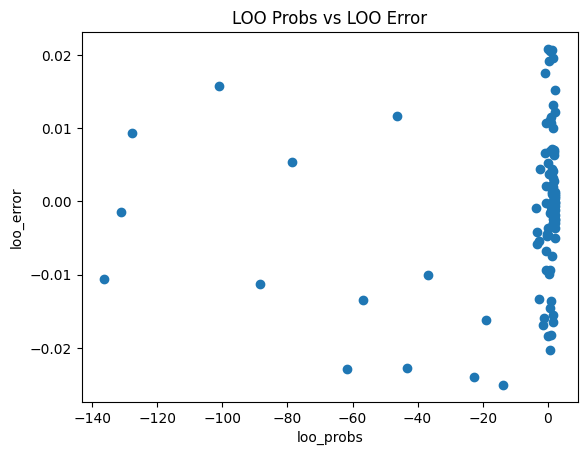

In [110]:
plt.scatter(loo_probs, loo_error)
plt.xlabel('loo_probs')
plt.ylabel('loo_error')
plt.title('LOO Probs vs LOO Error')
plt.show()


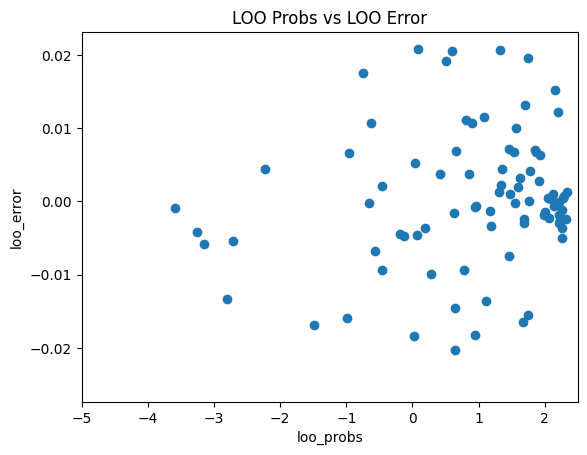

In [112]:
plt.scatter(loo_probs, loo_error)
plt.xlim(-5,2.5)
plt.xlabel('loo_probs')
plt.ylabel('loo_error')
plt.title('LOO Probs vs LOO Error')
plt.show()

In [113]:
from scipy.stats import spearmanr


# Calculate Spearman's rank correlation coefficient
corr, p_value = spearmanr(loo_error, loo_probs)

print("Spearman's rank correlation coefficient:", corr)
print("p-value:", p_value)


Spearman's rank correlation coefficient: 0.23017101710171015
p-value: 0.021234072369726537
